# Clustering analysis using appraisal theory to derive facial expressions

The purpose of this analysis is to derive facial expression from data based on psychologically meaningful annotations, and then use these facial factors to train a classifier to predict outcomes.  This analysis is inspired by Stratou et al (2017) and Hoegen et al (2023), but draw from appraisal theory of emotions to form meaningful emotions clusters.  Using appraisals to understanding facial expressions in not new, and work is done by both Ong et all (2021) or Houlihan et al (2022), Houlihan et al (2023).

In [1]:
##### Standard packages
import numpy as np
import pandas as pd
import os
import math
import random
import re

##### Plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Decision trees and random forrests
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier

## metrics 
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

## misc
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE # oversampling for imbalanced datasets


##### Saving 
import pickle


## Data loading and cleaning

First thing we do is that we find all relevant participant and file names

Now we load all the files

In [2]:
d_au_annotation_unfiltered = pd.read_csv("../data/d_au_annotation.csv")
d_au_annotation_unfiltered.rename(columns=lambda x: x[:-2] if x.endswith("_r") else x, inplace=True)

## Factor analysis for all participants

First we add factors from the factor analysis conducted in R

In [3]:
d_au_relevance = d_au_annotation_unfiltered.query("~(goal_relevance != goal_relevance)").copy() # remove na

# define the factors
f1 = ["AU06", "AU07", "AU09", "AU10"]
f1_weights = [0.854, 0.712, 0.302, 0.735]
f2 = ["AU01", "AU02"]
f2_weights = [0.986, 0.800]
f3 = ["AU15", "AU17"]
f3_weights = [0.324, 0.991]
f4 = ["AU12", "AU14"]
f4_weights = [0.776, 0.458]
f5 = ["AU25", "AU26"]
f5_weights = [0.781, 0.689]
f6 = ["AU23"]
f6_weights = [0.817]
f7 = ["AU09", "AU15"]
f7_weights = [0.304, 0.328]


# Create expressivity metrics
# # mean activation
# d_au_relevance["f1_mean"]  = d_au_relevance[f1].mean(axis=1)
# d_au_relevance["f2_mean"]  = d_au_relevance[f2].mean(axis=1)
# d_au_relevance["f3_mean"]  = d_au_relevance[f3].mean(axis=1)
# d_au_relevance["f4_mean"]  = d_au_relevance[f4].mean(axis=1)
# d_au_relevance["f5_mean"]  = d_au_relevance[f5].mean(axis=1)
# d_au_relevance["f6_mean"]  = d_au_relevance[f6].mean(axis=1)
# d_au_relevance["f7_mean"]  = d_au_relevance[f7].mean(axis=1)

# weighted mean activation
d_au_relevance["f1_mean"]  = d_au_relevance[f1].mul(f1_weights).sum(axis=1)/len(f1)
d_au_relevance["f2_mean"]  = d_au_relevance[f2].mul(f2_weights).sum(axis=1)/len(f2)
d_au_relevance["f3_mean"]  = d_au_relevance[f3].mul(f3_weights).sum(axis=1)/len(f3)
d_au_relevance["f4_mean"]  = d_au_relevance[f4].mul(f4_weights).sum(axis=1)/len(f4)
d_au_relevance["f5_mean"]  = d_au_relevance[f5].mul(f5_weights).sum(axis=1)/len(f5)
d_au_relevance["f6_mean"]  = d_au_relevance[f6].mul(f6_weights).sum(axis=1)/len(f6)
d_au_relevance["f7_mean"]  = d_au_relevance[f7].mul(f7_weights).sum(axis=1)/len(f7)

# # sum variables
# d_au_relevance["f1_sum"]  = d_au_relevance[f1].sum(axis=1)
# d_au_relevance["f2_sum"]  = d_au_relevance[f2].sum(axis=1)
# d_au_relevance["f3_sum"]  = d_au_relevance[f3].sum(axis=1)
# d_au_relevance["f4_sum"]  = d_au_relevance[f4].sum(axis=1)
# d_au_relevance["f5_sum"]  = d_au_relevance[f5].sum(axis=1)
# d_au_relevance["f6_sum"]  = d_au_relevance[f6].sum(axis=1)
# d_au_relevance["f7_sum"]  = d_au_relevance[f7].sum(axis=1)

# weighted sum variables
d_au_relevance["f1_sum"]  = d_au_relevance[f1].mul(f1_weights).sum(axis=1)
d_au_relevance["f2_sum"]  = d_au_relevance[f2].mul(f2_weights).sum(axis=1)
d_au_relevance["f3_sum"]  = d_au_relevance[f3].mul(f3_weights).sum(axis=1)
d_au_relevance["f4_sum"]  = d_au_relevance[f4].mul(f4_weights).sum(axis=1)
d_au_relevance["f5_sum"]  = d_au_relevance[f5].mul(f5_weights).sum(axis=1)
d_au_relevance["f7_sum"]  = d_au_relevance[f7].mul(f7_weights).sum(axis=1)


# # sd
# d_au_relevance["f1_sd"]  = d_au_relevance[f1].std(axis=1)
# d_au_relevance["f2_sd"]  = d_au_relevance[f2].std(axis=1)
# d_au_relevance["f3_sd"]  = d_au_relevance[f3].std(axis=1)
# d_au_relevance["f4_sd"]  = d_au_relevance[f4].std(axis=1)
# d_au_relevance["f5_sd"]  = d_au_relevance[f5].std(axis=1)
# d_au_relevance["f6_sd"]  = 0 # as it's only one AU
# d_au_relevance["f7_sd"]  = d_au_relevance[f7].std(axis=1)

# sd
d_au_relevance["f1_sd"]  = d_au_relevance[f1].mul(f1_weights).std(axis=1)
d_au_relevance["f2_sd"]  = d_au_relevance[f2].mul(f2_weights).std(axis=1)
d_au_relevance["f3_sd"]  = d_au_relevance[f3].mul(f3_weights).std(axis=1)
d_au_relevance["f4_sd"]  = d_au_relevance[f4].mul(f4_weights).std(axis=1)
d_au_relevance["f5_sd"]  = d_au_relevance[f5].mul(f5_weights).std(axis=1)
d_au_relevance["f7_sd"]  = d_au_relevance[f7].mul(f7_weights).std(axis=1)


# change variables
d_au_relevance["f1_change"]  = d_au_relevance["f1_mean"].diff().fillna(0)
d_au_relevance["f2_change"]  = d_au_relevance["f2_mean"].diff().fillna(0)
d_au_relevance["f3_change"]  = d_au_relevance["f3_mean"].diff().fillna(0)
d_au_relevance["f4_change"]  = d_au_relevance["f4_mean"].diff().fillna(0)
d_au_relevance["f5_change"]  = d_au_relevance["f5_mean"].diff().fillna(0)
d_au_relevance["f6_change"]  = d_au_relevance["f6_mean"].diff().fillna(0)
d_au_relevance["f7_change"]  = d_au_relevance["f7_mean"].diff().fillna(0)

# max
# d_au_relevance["f1_max"]  = d_au_relevance[f1].max(axis=1)
# d_au_relevance["f2_max"]  = d_au_relevance[f2].max(axis=1)
# d_au_relevance["f3_max"]  = d_au_relevance[f3].max(axis=1)
# d_au_relevance["f4_max"]  = d_au_relevance[f4].max(axis=1)
# d_au_relevance["f5_max"]  = d_au_relevance[f5].max(axis=1)
# d_au_relevance["f6_max"]  = d_au_relevance[f6].max(axis=1)
# d_au_relevance["f7_max"]  = d_au_relevance[f7].max(axis=1)
# max
d_au_relevance["f1_max"]  = d_au_relevance[f1].mul(f1_weights).max(axis=1)
d_au_relevance["f2_max"]  = d_au_relevance[f2].mul(f2_weights).max(axis=1)
d_au_relevance["f3_max"]  = d_au_relevance[f3].mul(f3_weights).max(axis=1)
d_au_relevance["f4_max"]  = d_au_relevance[f4].mul(f4_weights).max(axis=1)
d_au_relevance["f5_max"]  = d_au_relevance[f5].mul(f5_weights).max(axis=1)
d_au_relevance["f7_max"]  = d_au_relevance[f7].mul(f7_weights).max(axis=1)

d_au_relevance.goal_relevance.value_counts()



goal_relevance
High      62773
Medium    35393
Low       20241
Name: count, dtype: int64

# Random Forests

In [4]:
# Base model
X = d_au_relevance.copy()
y = d_au_relevance["goal_relevance"]
average_classification = []
f1_score_list = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["High"] * len(y_test)

    average_classification.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification))
print(np.mean(f1_score_list))

Accuracy: 0.5299665005770909
F1: 0.3671511652418375
Accuracy: 0.5297131435971061
F1: 0.3668609577867775
Accuracy: 0.5277425893083354
F1: 0.3646062399765382
Accuracy: 0.5293471835149058
F1: 0.36644189588286813
Accuracy: 0.5332601413168933
F1: 0.3709303733325712
Accuracy: 0.529093826534921
F1: 0.3661518638287065
Accuracy: 0.5304450637615066
F1: 0.36769953045867154
Accuracy: 0.5303324606592912
F1: 0.36757048034878725
Accuracy: 0.5308954761703685
F1: 0.3682158723510344
Accuracy: 0.528474509472736
F1: 0.3654431989955677
0.5299270894913154
0.3671071578203359


### AU model

In [5]:
#split dataset in features and target variable
feature_cols_au = [col_name for col_name in d_au_relevance.columns if "au" in col_name.lower()]
X_au = d_au_relevance[feature_cols_au] # Features
y_au = d_au_relevance["goal_relevance"] # Target variable


X_train_au, X_test_au, y_train_au, y_test_au = train_test_split(X_au, y_au, test_size=0.3, random_state=1) # 70% training and 30% test

In [9]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au.fit(X_train_au, y_train_au)

print(grid_seach_au.best_params_)
print(grid_seach_au.score(X_train_au, y_train_au))
print(grid_seach_au.score(X_test_au, y_test_au))
best_rf_au = grid_seach_au.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.6890956034940399
0.6650339216845425


In [10]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au = []
f1_score_list_au = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au, y_au, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au))
print(np.mean(f1_score_list_au))

Accuracy: 0.6622469949047096
F1: 0.6151416453088794
Accuracy: 0.6664133096866819
F1: 0.618913696214578
Accuracy: 0.667848999239929
F1: 0.6229644334009505
Accuracy: 0.6645553585001267
F1: 0.6163459790741238
Accuracy: 0.662387748782479
F1: 0.614924278217474
Accuracy: 0.6628944627424486
F1: 0.6152092752305679
Accuracy: 0.6654561833178504
F1: 0.6171749271717749
Accuracy: 0.6620499394758326
F1: 0.6146730892014642
Accuracy: 0.6712833938575008
F1: 0.625839297775662
Accuracy: 0.6677082453621598
F1: 0.6219730485921083
0.6652844635869719
0.6183159670187582


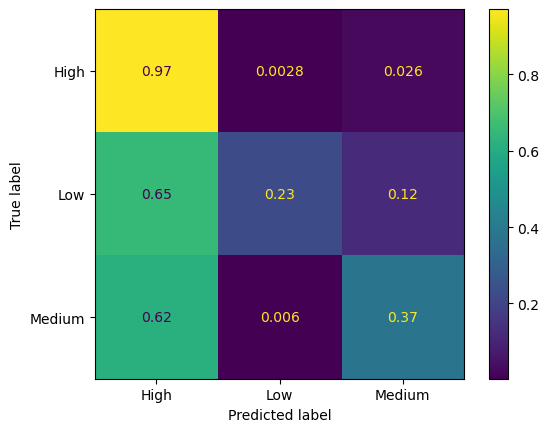

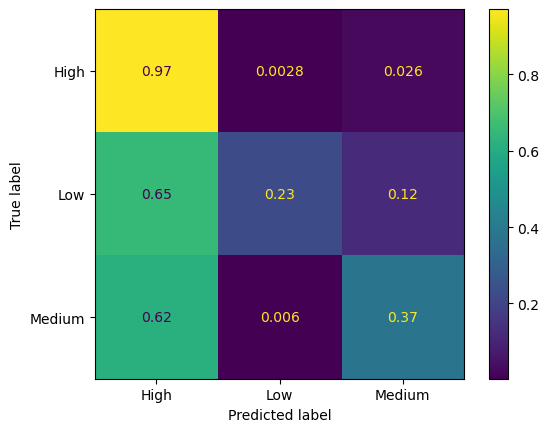

In [11]:
y_pred = best_rf_au.predict(X_test_au)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au, y_pred, normalize="true").plot()

<Axes: >

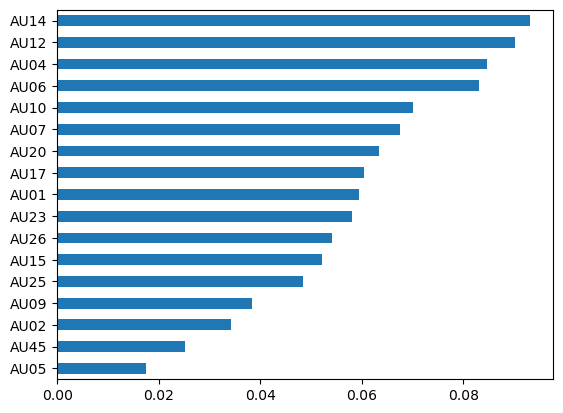

In [12]:
feature_importance_au = pd.Series(best_rf_au.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au.plot.barh()

In [13]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_full = re.compile(r"f\d+_(mean|sum|sd|change|max)")

# Extract matching column names
feature_cols_f_full = [col_name for col_name in d_au_relevance.columns if pattern_f_full.match(col_name)]
X_ff = d_au_relevance[feature_cols_f_full] # Features
y_ff = d_au_relevance["goal_relevance"] # Target variable


X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(X_ff, y_ff, test_size=0.3, random_state=1) # 70% training and 30% test

In [14]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_full)))]}

rf = RandomForestClassifier()

grid_seach_ff = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_ff.fit(X_train_ff, y_train_ff)

# print best fits
print(grid_seach_ff.best_params_)
print(grid_seach_ff.score(X_train_ff, y_train_ff))
best_rf_ff = grid_seach_ff.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 30}
0.6615148882775927


In [15]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_full))), random_state=1)

average_classification_ff = []
f1_score_list_ff = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_ff, y_ff, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_ff.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_ff.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_ff))
print(np.mean(f1_score_list_ff))

Accuracy: 0.6345747825352589
F1: 0.5780315179458495
Accuracy: 0.6386003434394617
F1: 0.5830646981228595
Accuracy: 0.6380936294794921
F1: 0.5830371693156968
Accuracy: 0.6329983391042423
F1: 0.573788154295706
Accuracy: 0.6367705430284605
F1: 0.5805271341035112
Accuracy: 0.6365171860484756
F1: 0.5806623633927236
Accuracy: 0.6316189511021029
F1: 0.5727103968178663
Accuracy: 0.6345184809841511
F1: 0.577383909965691
Accuracy: 0.6404864454015708
F1: 0.5852295673261025
Accuracy: 0.6335895053908736
F1: 0.5766402083961968
0.635776820651409
0.5791075119682203


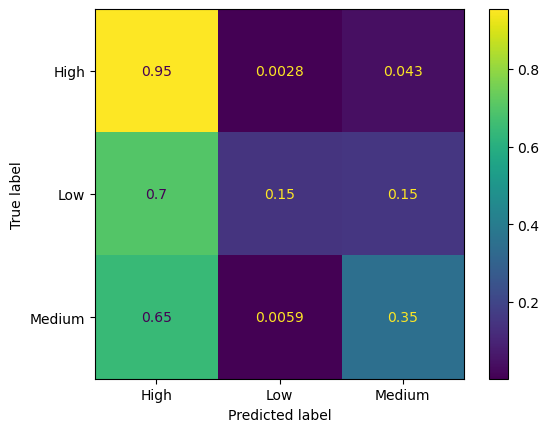

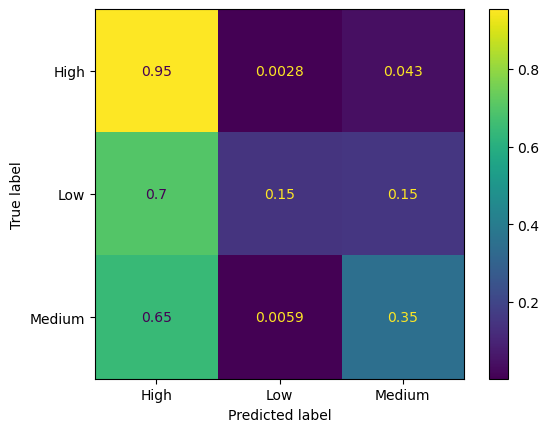

In [16]:
y_pred = best_rf_ff.predict(X_test_ff)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_ff, y_pred, normalize="true").plot()
plt.show()

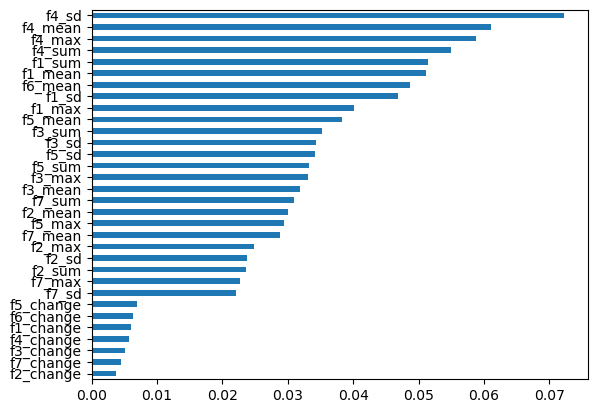

Index(['f2_change', 'f7_change', 'f3_change', 'f4_change', 'f1_change',
       'f6_change', 'f5_change', 'f7_sd', 'f7_max', 'f2_sum', 'f2_sd',
       'f2_max', 'f7_mean', 'f5_max', 'f2_mean', 'f7_sum', 'f3_mean', 'f3_max',
       'f5_sum', 'f5_sd', 'f3_sd', 'f3_sum', 'f5_mean', 'f1_max', 'f1_sd',
       'f6_mean', 'f1_mean', 'f1_sum', 'f4_sum', 'f4_max', 'f4_mean', 'f4_sd'],
      dtype='object')


In [17]:
feature_importance_ff = pd.Series(best_rf_ff.feature_importances_, index=X_train_ff.columns).sort_values(ascending=True)
feature_importance_ff.plot.barh()

plt.show()
print(feature_importance_ff.index)

In [18]:
#split dataset in features and target variable

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f = [col_name for col_name in d_au_relevance.columns if pattern_f.match(col_name)]
X_f = d_au_relevance[feature_cols_f] # Features
y_f = d_au_relevance["goal_relevance"] # Target variable


X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.3, random_state=1) # 70% training and 30% test

In [19]:
# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()
# #£££#wdsdljsldj 
grid_seach_f = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f.fit(X_train_f, y_train_f)

# print best fits
print(grid_seach_f.best_params_)
print(grid_seach_f.score(X_train_f, y_train_f))
best_rf_f = grid_seach_f.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.6712151923169731


In [20]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f = []
f1_score_list_f = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f))
print(np.mean(f1_score_list_f))

Accuracy: 0.6435267291613884
F1: 0.5943153675024352
Accuracy: 0.6455817357768207
F1: 0.5944430888421938
Accuracy: 0.6431044675280804
F1: 0.591361648790926
Accuracy: 0.6474678377389297
F1: 0.5969668849954392
Accuracy: 0.643188919854742
F1: 0.5897254696194715
Accuracy: 0.649100582721054
F1: 0.6003633898283098
Accuracy: 0.6421754919348028
F1: 0.5891367435731861
Accuracy: 0.6465951636967598
F1: 0.5947904648354305
Accuracy: 0.6471018776567294
F1: 0.5970986159719084
Accuracy: 0.6420628888325873
F1: 0.5905742610081082
0.6449905694901894
0.5938775934967409


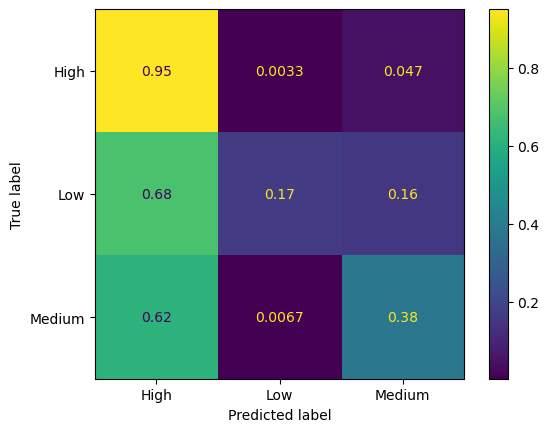

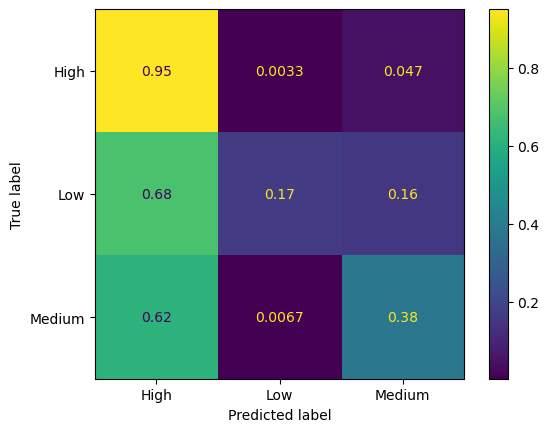

In [21]:
y_pred = best_rf_f.predict(X_test_f)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f, y_pred, normalize="true").plot()

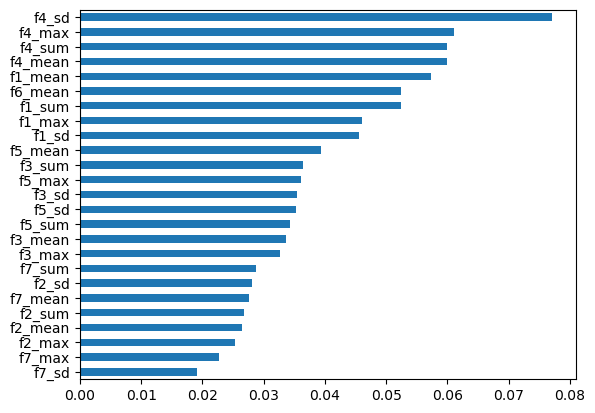

Index(['f7_sd', 'f7_max', 'f2_max', 'f2_mean', 'f2_sum', 'f7_mean', 'f2_sd',
       'f7_sum', 'f3_max', 'f3_mean', 'f5_sum', 'f5_sd', 'f3_sd', 'f5_max',
       'f3_sum', 'f5_mean', 'f1_sd', 'f1_max', 'f1_sum', 'f6_mean', 'f1_mean',
       'f4_mean', 'f4_sum', 'f4_max', 'f4_sd'],
      dtype='object')


In [22]:
feature_importance_f = pd.Series(best_rf_f.feature_importances_, index=X_train_f.columns).sort_values(ascending=True)
feature_importance_f.plot.barh()

plt.show()
print(feature_importance_f.index)

## SMOTE (oversampling)

##### AU oversampling

In [6]:
# resample
smote=SMOTE(sampling_strategy="auto")
print(y_au.value_counts())
X_au_smote, y_au_smote = smote.fit_resample(X_au, y_au)
print(y_au_smote.value_counts())



goal_relevance
High      62773
Medium    35393
Low       20241
Name: count, dtype: int64
goal_relevance
Low       62773
Medium    62773
High      62773
Name: count, dtype: int64


In [24]:
# Au oversampling
X_train_au_smote, X_test_au_smote, y_train_au_smote, y_test_au_smote = train_test_split(X_au_smote, y_au_smote, test_size=0.3, random_state=1) # 70% training and 30% test

In [25]:
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_au)))]}

rf = RandomForestClassifier()

grid_seach_au_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_au_smote.fit(X_train_au_smote, y_train_au_smote)

#print best fits
print(grid_seach_au_smote.best_params_)
print(grid_seach_au_smote.score(X_train_au_smote, y_train_au_smote))
best_rf_au_smote = grid_seach_au_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.7409556754132435


In [26]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_au))), random_state=1)

average_classification_au_smote = []
f1_score_list_au_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_au_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_au_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_au_smote))
print(np.mean(f1_score_list_au_smote))

Accuracy: 0.7220865193996036
F1: 0.7224352542096104
Accuracy: 0.720351883319173
F1: 0.7208510209851556
Accuracy: 0.7202810818465024
F1: 0.7208861545689552
Accuracy: 0.7185287453979042
F1: 0.7191497966421656
Accuracy: 0.7169711129991504
F1: 0.7174910296829892
Accuracy: 0.7118557065986972
F1: 0.7123584342629122
Accuracy: 0.7139089493061456
F1: 0.7146662042957594
Accuracy: 0.7208120928915321
F1: 0.7212675385093207
Accuracy: 0.7109706881903144
F1: 0.7116681004865053
Accuracy: 0.7206350892098555
F1: 0.7212943265793248
0.7176401869158877
0.71820678602227


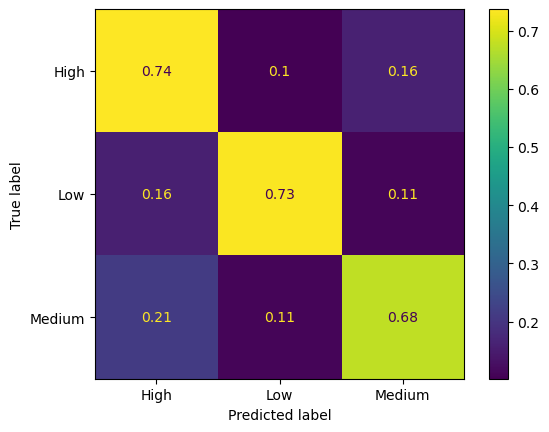

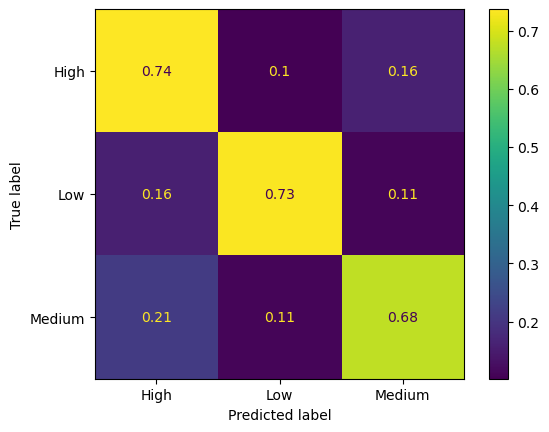

<Axes: >

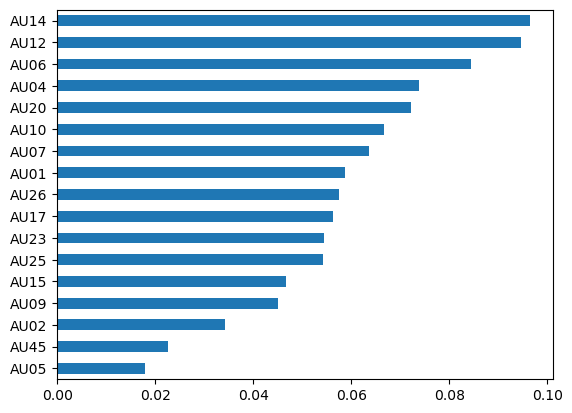

In [27]:
y_pred = best_rf_au_smote.predict(X_test_au_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_au_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_au_smote = pd.Series(best_rf_au_smote.feature_importances_, index=X_train_au.columns).sort_values(ascending=True)
feature_importance_au_smote.plot.barh()

### BASE model

In [28]:
average_classification_smote = []
f1_score_list_smote = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_au_smote, y_au_smote, test_size=0.3) # 70% training and 30% test

    #Predict the response for test dataset
    y_pred = ["High"] * len(y_test)

    average_classification_smote.append(metrics.accuracy_score(y_test, y_pred))
    
    # Calculate F1 score for each class separately

    # f1_per_class = f1_score(y_test, y_pred, average=None)
    # print(f1_per_class)

    # Calculate micro-average F1 score
    # f1_micro = f1_score(y_test, y_pred, average='micro')

    # Calculate macro-average F1 score
    # f1_macro = f1_score(y_test, y_pred, average='macro')

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))

print(np.mean(average_classification_smote))
print(np.mean(f1_score_list_smote))

Accuracy: 0.3343068535825545
F1: 0.16751929595833825
Accuracy: 0.33303242707448316
F1: 0.16640345010440444
Accuracy: 0.33128009062588504
F1: 0.16487364186975653
Accuracy: 0.3344484565278958
F1: 0.167643447788054
Accuracy: 0.3348909657320872
F1: 0.16803163974888854
Accuracy: 0.33030657037666383
F1: 0.16402599650861327
Accuracy: 0.33260761823845936
F1: 0.166032110572048
Accuracy: 0.3342006513735486
F1: 0.1674262042422482
Accuracy: 0.33092608326253187
F1: 0.16456522110533822
Accuracy: 0.33058977626734637
F1: 0.16427241832427142
0.33265894930614553
0.1660793426221961


### Factor subset

In [29]:
# Create the factors on the smote'd dataset
X_f_smote = X_au_smote
y_f_smote = y_au_smote.copy()

# weighted mean activation
X_f_smote["f1_mean"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)/len(f1)
X_f_smote["f2_mean"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)/len(f2)
X_f_smote["f3_mean"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)/len(f3)
X_f_smote["f4_mean"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)/len(f4)
X_f_smote["f5_mean"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)/len(f5)
X_f_smote["f6_mean"]  = X_f_smote[f6].mul(f6_weights).sum(axis=1)/len(f6)
X_f_smote["f7_mean"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)/len(f7)

# weighted sum variables
X_f_smote["f1_sum"]  = X_f_smote[f1].mul(f1_weights).sum(axis=1)
X_f_smote["f2_sum"]  = X_f_smote[f2].mul(f2_weights).sum(axis=1)
X_f_smote["f3_sum"]  = X_f_smote[f3].mul(f3_weights).sum(axis=1)
X_f_smote["f4_sum"]  = X_f_smote[f4].mul(f4_weights).sum(axis=1)
X_f_smote["f5_sum"]  = X_f_smote[f5].mul(f5_weights).sum(axis=1)
X_f_smote["f7_sum"]  = X_f_smote[f7].mul(f7_weights).sum(axis=1)


# sd
X_f_smote["f1_sd"]  = X_f_smote[f1].mul(f1_weights).std(axis=1)
X_f_smote["f2_sd"]  = X_f_smote[f2].mul(f2_weights).std(axis=1)
X_f_smote["f3_sd"]  = X_f_smote[f3].mul(f3_weights).std(axis=1)
X_f_smote["f4_sd"]  = X_f_smote[f4].mul(f4_weights).std(axis=1)
X_f_smote["f5_sd"]  = X_f_smote[f5].mul(f5_weights).std(axis=1)
X_f_smote["f7_sd"]  = X_f_smote[f7].mul(f7_weights).std(axis=1)

# max
X_f_smote["f1_max"]  = X_f_smote[f1].mul(f1_weights).max(axis=1)
X_f_smote["f2_max"]  = X_f_smote[f2].mul(f2_weights).max(axis=1)
X_f_smote["f3_max"]  = X_f_smote[f3].mul(f3_weights).max(axis=1)
X_f_smote["f4_max"]  = X_f_smote[f4].mul(f4_weights).max(axis=1)
X_f_smote["f5_max"]  = X_f_smote[f5].mul(f5_weights).max(axis=1)
X_f_smote["f7_max"]  = X_f_smote[f7].mul(f7_weights).max(axis=1)

X_f_smote = X_f_smote[feature_cols_f]

In [30]:
X_train_f_smote, X_test_f_smote, y_train_f_smote, y_test_f_smote = train_test_split(X_f_smote, y_f_smote, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f)))]}

rf = RandomForestClassifier()

grid_seach_f_smote = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote.fit(X_train_f_smote, y_train_f_smote)

# best parameters
print(grid_seach_f_smote.best_params_)
print(grid_seach_f_smote.score(X_train_f_smote, y_train_f_smote))
best_rf_f_smote = grid_seach_f_smote.best_estimator_

{'criterion': 'gini', 'max_depth': 10, 'max_features': 5, 'n_estimators': 50}
0.6913816253612799


In [31]:
# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f))))

average_classification_f_smote = []
f1_score_list_f_smote = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote, y_f_smote, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote))
print(np.mean(f1_score_list_f_smote))


Accuracy: 0.6704191447182102
F1: 0.6709640414913369
Accuracy: 0.6671976777116964
F1: 0.6677924880164291
Accuracy: 0.6697465307278392
F1: 0.6704472652610398
Accuracy: 0.6674985839705466
F1: 0.6681689445027966
Accuracy: 0.66928632115548
F1: 0.6701202614005044
Accuracy: 0.6702421410365336
F1: 0.6709518481289365
Accuracy: 0.6684190031152648
F1: 0.6690806354110633
Accuracy: 0.6723838855848202
F1: 0.6731335484188776
Accuracy: 0.6644895213820448
F1: 0.6653757407542715
Accuracy: 0.6727909940526763
F1: 0.67356958938182
0.6692473803455112
0.6699604362767075


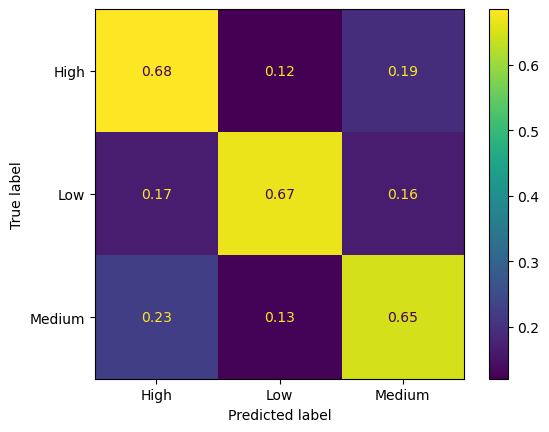

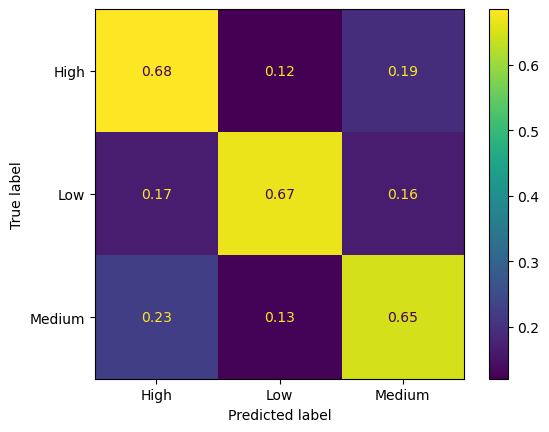

<Axes: >

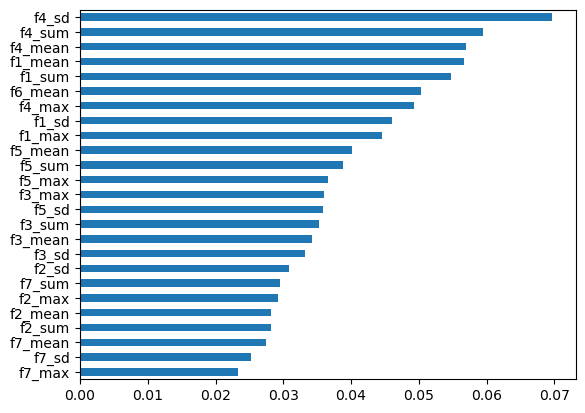

In [32]:
y_pred = best_rf_f_smote.predict(X_test_f_smote)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote = pd.Series(best_rf_f_smote.feature_importances_, index=X_train_f_smote.columns).sort_values(ascending=True)
feature_importance_f_smote.plot.barh()

In [36]:
print(list(feature_importance_au_smote.index))

['AU05', 'AU45', 'AU02', 'AU09', 'AU15', 'AU25', 'AU23', 'AU17', 'AU26', 'AU01', 'AU07', 'AU10', 'AU20', 'AU04', 'AU06', 'AU12', 'AU14']


## Stratou

{'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'n_estimators': 50}
0.6846377339311046
Accuracy: 0.6671799773435287
F1: 0.6677722808220963
Accuracy: 0.6617636646842254
F1: 0.6622228315042191
Accuracy: 0.6664719626168224
F1: 0.6672340756624134
Accuracy: 0.6595865193996036
F1: 0.6601313012540562
Accuracy: 0.667374681393373
F1: 0.6678804900346086
Accuracy: 0.6607193429623336
F1: 0.661249086453473
Accuracy: 0.6700474369866893
F1: 0.6704460703600953
Accuracy: 0.6709501557632399
F1: 0.6715172683215362
Accuracy: 0.6745964316057774
F1: 0.6749998433978427
Accuracy: 0.6675870858113849
F1: 0.6679487577582601
0.6666277258566978
0.6671402005568601


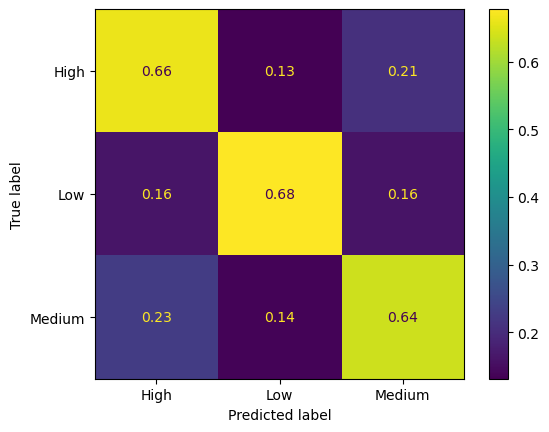

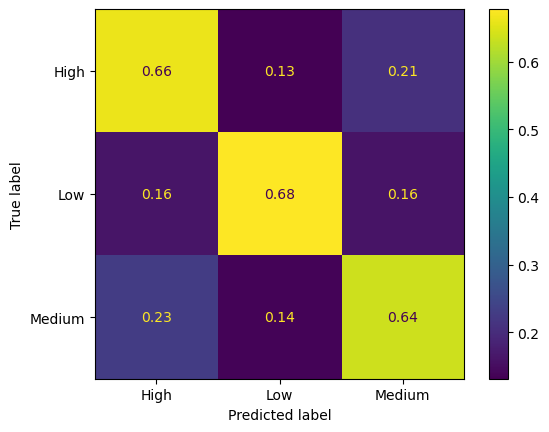

<Axes: >

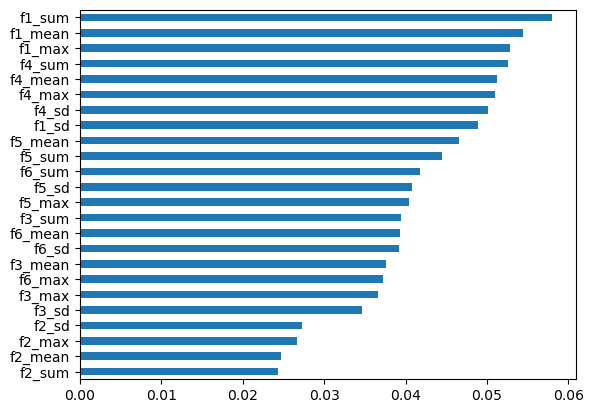

In [7]:
f1_strat = ["AU06", "AU07", "AU12"]
f1_weights_strat = [0.982, 0.446, 0.882]
f2_strat = ["AU01", "AU02"]
f2_weights_strat = [0.981, 0.873]
f3_strat = ["AU20", "AU25", "AU26"]
f3_weights_strat = [0.377, 0.951, 0.786]
f4_strat = ["AU14", "AU17", "AU23"]
f4_weights_strat = [0.724, 0.632, 0.710]
f5_strat = ["AU04", "AU07", "AU09"]
f5_weights_strat = [0.703, 0.384, 0.390]
f6_strat = ["AU10", "AU15", "AU17"]
f6_weights_strat = [0.488, 0.504, 0.420]

# Create the factors on the smote'd dataset
X_f_smote_strat = X_au_smote.copy()
y_f_smote_strat = y_au_smote.copy()

# weighted mean activation
X_f_smote_strat["f1_mean"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)/len(f1_strat)
X_f_smote_strat["f2_mean"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)/len(f2_strat)
X_f_smote_strat["f3_mean"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)/len(f3_strat)
X_f_smote_strat["f4_mean"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)/len(f4_strat)
X_f_smote_strat["f5_mean"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)/len(f5_strat)
X_f_smote_strat["f6_mean"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)/len(f6_strat)

# weighted sum variables
X_f_smote_strat["f1_sum"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).sum(axis=1)
X_f_smote_strat["f2_sum"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).sum(axis=1)
X_f_smote_strat["f3_sum"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).sum(axis=1)
X_f_smote_strat["f4_sum"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).sum(axis=1)
X_f_smote_strat["f5_sum"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).sum(axis=1)
X_f_smote_strat["f6_sum"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).sum(axis=1)


# sd
X_f_smote_strat["f1_sd"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).std(axis=1)
X_f_smote_strat["f2_sd"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).std(axis=1)
X_f_smote_strat["f3_sd"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).std(axis=1)
X_f_smote_strat["f4_sd"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).std(axis=1)
X_f_smote_strat["f5_sd"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).std(axis=1)
X_f_smote_strat["f6_sd"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).std(axis=1)

# max
X_f_smote_strat["f1_max"]  = X_f_smote_strat[f1_strat].mul(f1_weights_strat).max(axis=1)
X_f_smote_strat["f2_max"]  = X_f_smote_strat[f2_strat].mul(f2_weights_strat).max(axis=1)
X_f_smote_strat["f3_max"]  = X_f_smote_strat[f3_strat].mul(f3_weights_strat).max(axis=1)
X_f_smote_strat["f4_max"]  = X_f_smote_strat[f4_strat].mul(f4_weights_strat).max(axis=1)
X_f_smote_strat["f5_max"]  = X_f_smote_strat[f5_strat].mul(f5_weights_strat).max(axis=1)
X_f_smote_strat["f6_max"]  = X_f_smote_strat[f6_strat].mul(f6_weights_strat).max(axis=1)

# Regular expression to match fX_mean, fX_sum, fX_sd, etc.
pattern_f_strat = re.compile(r"f\d+_(mean|sum|sd|max)")

# Extract matching column names
feature_cols_f_strat = [col_name for col_name in X_f_smote_strat.columns if pattern_f_strat.match(col_name)]

X_f_smote_strat = X_f_smote_strat[feature_cols_f_strat]

# divide 
X_train_f_smote_strat, X_test_f_smote_strat, y_train_f_smote_strat, y_test_f_smote_strat = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3, random_state=1) # 70% training and 30% test

# grid search for factor tree
param_grid = {"n_estimators": [10, 30, 50],
              "max_depth": [4, 6, 8, 10],
              "criterion": ["gini"],
              "max_features": [int(np.sqrt(len(feature_cols_f_strat)))]}

rf = RandomForestClassifier()

grid_seach_f_smote_strat = GridSearchCV(rf, param_grid=param_grid, cv=10, scoring="accuracy")

grid_seach_f_smote_strat.fit(X_train_f_smote_strat, y_train_f_smote_strat)

# best parameters
print(grid_seach_f_smote_strat.best_params_)
print(grid_seach_f_smote_strat.score(X_train_f_smote_strat, y_train_f_smote_strat))
best_rf_f_smote_strat = grid_seach_f_smote_strat.best_estimator_


# Create random forest

clf = RandomForestClassifier(n_estimators=50, criterion="gini" , max_depth=10, max_features=int(np.sqrt(len(feature_cols_f_strat))))

average_classification_f_smote_strat = []
f1_score_list_f_smote_strat = []
# 10 fold-crossvalidation
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_f_smote_strat, y_f_smote_strat, test_size=0.3) # 70% training and 30% test

    # Train Decision Tree Classifer
    clf = clf.fit(X_train,y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    average_classification_f_smote_strat.append(metrics.accuracy_score(y_test, y_pred))
    

    # Calculate weighted-average F1 score
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_score_list_f_smote_strat.append(f1_weighted)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("F1:",f1_score(y_test, y_pred, average='weighted'))
    
print(np.mean(average_classification_f_smote_strat))
print(np.mean(f1_score_list_f_smote_strat))

# plots
y_pred = best_rf_f_smote_strat.predict(X_test_f_smote_strat)
# cm = confusion_matrix(y_test, y_pred, labels=["High", "Low", "Medium"])
ConfusionMatrixDisplay.from_predictions(y_test_f_smote_strat, y_pred, normalize="true").plot()
plt.show()
feature_importance_f_smote_strat = pd.Series(best_rf_f_smote_strat.feature_importances_, index=X_train_f_smote_strat.columns).sort_values(ascending=True)
feature_importance_f_smote_strat.plot.barh()

In [9]:
print(list(feature_importance_f_smote_strat.index))


['f2_sum', 'f2_mean', 'f2_max', 'f2_sd', 'f3_sd', 'f3_max', 'f6_max', 'f3_mean', 'f6_sd', 'f6_mean', 'f3_sum', 'f5_max', 'f5_sd', 'f6_sum', 'f5_sum', 'f5_mean', 'f1_sd', 'f4_sd', 'f4_max', 'f4_mean', 'f4_sum', 'f1_max', 'f1_mean', 'f1_sum']
